# Advanced indexation with Pyxem
In this notebook we illustrate an advanced workflow whereby a dual phase material is indexed in two stages. The notebook runs through the following steps
* <a href=#s1>Loading the data and processing the images</a>
* <a href=#s2>Indexing the matrix phase</a>
    * <a href=#s2a>Simulating a template library</a>
    * <a href=#s2b>Testing on a single image</a>
    * <a href=#s2c>Indexing the dataset</a>
* <a href=#s3>Creating the mask and masking the dataset</a>
* <a href=#s4>Indexing the precipitate</a>
    * <a href=#s4a>Simulating a template library</a>
    * <a href=#s4b>Testing on a single image</a>
    * <a href=#s4c>Indexing the dataset</a>
* <a href=#s5>Creating a summarizing figure</a>

In [1]:
import numpy as np
import hyperspy.api as hs
import matplotlib.pyplot as plt

In [2]:
import os

file_path = "data/201009A17-FullData4xbin.hspy"
if not os.path.isfile(file_path):
    print("File does not exist, will be downloaded from Zenodo")
    import wget
    wget.download("https://zenodo.org/record/5597738/files/201009A17-FullData4xbin.hspy?download=1", file_path)
else:
    print("File already exists!")

File already exists!


### <a id="s1"></a> Preliminary data loading and image processing

In [3]:
data_file = hs.load("data/201009A17-FullData4xbin.hspy", lazy=True)
data_file.data = data_file.data.rechunk(("auto", "auto", None, None))
subset = data_file

# change the data type to float
subset.change_dtype(np.float32)

#############
# Centering #
#############
# center the direct beam
subset.center_direct_beam(
        method="blur",
        half_square_width=50,
        sigma=1.5,
        )

#########################
# Affine transformation #
#########################
# mapping an affine transformation to it
from pyxem.utils.expt_utils import convert_affine_to_transform, apply_transformation

# define the affine transform matrices obtained from manual iteration to see what fits templates best
transform = convert_affine_to_transform(np.array([[ 0.93356802, -0.04315628,  0.        ],
                                                  [-0.02749365,  0.96883687,  0.        ],
                                                  [ 0.        ,  0.        ,  1.        ]]), subset.data.shape[-2:])
subset.map(apply_transformation, transformation=transform, keep_dtype=True)

###################
# Image Filtering #
###################
from scipy.ndimage import gaussian_filter
from skimage.exposure import rescale_intensity

#
# Difference of Gaussians for subtracting backgrounds
#
def subtract_background_dog(z, sigma_min, sigma_max):
    blur_max = gaussian_filter(z, sigma_max)
    blur_min = gaussian_filter(z, sigma_min)
    return np.maximum(np.where(blur_min > blur_max, z, 0) - blur_max, 0)
    
import skimage.filters as skifi

#
# Processing a single image
#
def process_image(image):
    # remove the entire diffuse background
    image = subtract_background_dog(image, 3, 8)
    # remove low intensity pixels
    image[image < 30] = 0
    # change the gamma of the images
    image = image**0.5
    # remap intensities to 0-1 range
    image = rescale_intensity(image)
    return image

subset.map(process_image)
print("Done")

Done


In [4]:
subset

<LazyElectronDiffraction2D, title: , dimensions: (260, 200|256, 256)>

##### Checking an individual image

In [5]:
test_image_path = "data/test_image.hspy"

import os

overwrite = True
if os.path.isfile(test_image_path):
    if not input("Already found a test image, overwrite? (y/N): ").lower() == "y":
        overwrite = False
if overwrite:
    scan_x_pos = 15
    scan_y_pos = 67
    test_image = subset.inav[scan_x_pos,scan_y_pos]
    test_image.compute()
    test_image.save(test_image_path)
else:
    print("Loaded test image")
    test_image = hs.load(test_image_path)

Already found a test image, overwrite? (y/N): 
Loaded test image


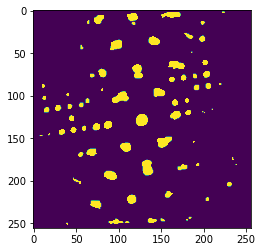

In [6]:
plt.imshow(test_image, vmax=0.01)

## <a id="s2"></a>Indexing the matrix phase

In [7]:
# Some additional parameters
diffraction_calibration = 0.01261  # px / Angstrom
subset.set_diffraction_calibration(diffraction_calibration)
# half size of the images
half_shape = (subset.data.shape[-2]//2, subset.data.shape[-1]//2)
# maximum radius in reciprocal space to calculate spot intensities for
reciprocal_radius = np.sqrt(half_shape[0]**2 + half_shape[1]**2)*diffraction_calibration

### <a id="s2a"></a> Creating a library
For the austenite, a 1 degree mesh should be fine.

In [8]:
# the grid
from diffsims.generators.rotation_list_generators import get_beam_directions_grid
grid_cub = get_beam_directions_grid("cubic", 1, mesh="spherified_cube_edge")

# the necessary imports
import diffpy
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.generators.library_generator import DiffractionLibraryGenerator

# importing the structures
aus = diffpy.structure.loadStructure("data/austeniteLP.cif")

# "The microscope"
diff_gen = DiffractionGenerator(accelerating_voltage=200,
                                scattering_params=None,
                                shape_factor_model="linear",
                                minimum_intensity=0.01,
                               )
lib_gen = DiffractionLibraryGenerator(diff_gen)

# Generating an austenite library
# "Library of structures and orientations"
library_phases_aus = StructureLibrary(["austenite"], [aus], [grid_cub])

/home/din14970/Documents/Programming/PythonProjects/FORKS/diffsims/diffsims/generators/sphere_mesh_generators.py:515: RuntimeWarning: invalid value encountered in true_divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


In [9]:
# Calculate the actual library
import os

lib_path = "data/Aus_lib_1deg_0.1me.pickle"
overwrite = True
if os.path.isfile(lib_path):
    if not input("Already found a library, overwrite? (y/N): ").lower() == "y":
        overwrite = False
if overwrite:
    diff_lib_aus = lib_gen.get_diffraction_library(library_phases_aus,
                                               calibration=diffraction_calibration*1.02, #fudge factor to match
                                               reciprocal_radius=reciprocal_radius,
                                               half_shape=half_shape,
                                               with_direct_beam=False,
                                               max_excitation_error=0.1)
    # saving the diffraction pattern library out to a file for easy loading
    diff_lib_aus.pickle_library(lib_path)
else:
    print("Loading existing library...")
    from diffsims.libraries.diffraction_library import load_DiffractionLibrary
    diff_lib_aus = load_DiffractionLibrary(lib_path, True)

Already found a library, overwrite? (y/N): 
Loading existing library...


### <a id="s2b"></a>Testing and finetuning on an individual image

In [10]:
from pyxem.utils import indexation_utils as iutls
from pyxem.utils import plotting_utils as putls
from pyxem.utils import polar_transform_utils as ptutls
from pyxem.utils import expt_utils as eutls
from Shortcuts210903NB import grid_to_xy

In [11]:
simulations = diff_lib_aus["austenite"]["simulations"]

/home/din14970/miniconda3/envs/hyperspy-dev/lib/python3.8/site-packages/numba/core/dispatcher.py:241: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ContextualVersionConflict((numpy 1.21.2 (/home/din14970/miniconda3/envs/hyperspy-dev/lib/python3.8/site-packages), Requirement.parse('numpy<1.21,>=1.17'), {'numba'}))'.
  entrypoints.init_all()


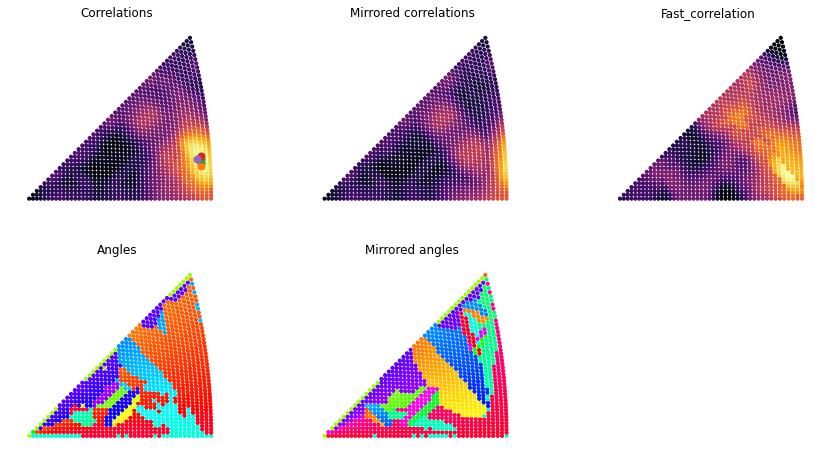

In [12]:
fast_cors = iutls.correlate_library_to_pattern_fast(test_image.data, simulations, max_r=115, normalize_image=False)

indexes, angles, corrs, angles_m, corrs_m = iutls.correlate_library_to_pattern(test_image.data, simulations, max_r=115, normalize_image=False)
indices_n, angles_n, correlations_n, signs_n = iutls.get_n_best_matches(test_image.data, simulations, n_best=5, max_r=115, normalize_image=False)

############################
# Plotting the test result #
############################
fig, ax = plt.subplots(ncols = 3, nrows = 2, figsize = (15, 8))
x, y = grid_to_xy(grid_cub)

ax = ax.ravel()
for i in ax:
    i.set_xlim(-0.05, 0.45)
    i.set_ylim(-0.05, 0.4)
    i.axis("off")
    i.set_aspect("equal")
    
s = 10

# to ensure the same color scale on mirror and non-mirror
all_cors = np.stack([corrs, corrs_m])
vmin = all_cors.min()
vmax = all_cors.max()

ax[0].scatter(x[indexes], y[indexes], s = s, c = corrs, cmap = "inferno", vmin = vmin, vmax = vmax)
ax[0].set_title("Correlations")
ax[1].scatter(x[indexes], y[indexes], s = s, c = corrs_m, cmap = "inferno", vmin = vmin, vmax = vmax)
ax[1].set_title("Mirrored correlations")
ax[2].scatter(x, y, s = s, c = fast_cors, cmap = "inferno")
ax[2].set_title("Fast_correlation")
ax[3].scatter(x[indexes], y[indexes], s = s, c = angles, cmap = "hsv")
ax[3].set_title("Angles")
ax[4].scatter(x[indexes], y[indexes], s = s, c = angles_m, cmap = "hsv")
ax[4].set_title("Mirrored angles")

for j, (i, ss) in enumerate(zip(indices_n, signs_n)):
    axis = None
    if ss == 1:
        axis = 0
    if ss ==  -1:
        axis = 1
    ax[axis].scatter(x[i], y[i], s = s*5, label = f"{j}: {correlations_n[j]}")

(<AxesSubplot:>,
 <matplotlib.collections.PathCollection at 0x7f98a80d2eb0>)

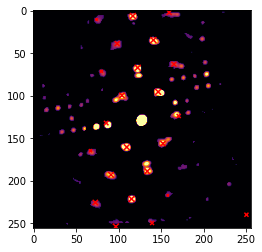

In [13]:
# signs will be 1 for the upper triangle, -1 for the lower triangle
sol_inx = 0 # the index of the solution to check
mirrored = signs_n[sol_inx] == -1
putls.plot_template_over_pattern(test_image.data,
                                 simulations[indices_n[sol_inx]],
                                 in_plane_angle=angles_n[sol_inx],
                                 coordinate_system = "cartesian", 
                                 size_factor = 10,
                                 vmax=0.1, 
                                 max_r = 200,
                                 mirrored_template=mirrored,
                                 find_direct_beam=True,
                                 cmap = "inferno"
                                )

### <a id="s2c"></a> Indexing the matrix phase of the entire dataset

In [14]:
result_aus_path = 'outputs/210921ResultAus.pickle'

import Shortcuts210903NB as sc
import pickle
import os

overwrite = True
if os.path.isfile(result_aus_path):
    if not input("Already found a solution, recalculate and overwrite? (y/N): ").lower() == "y":
        overwrite = False
if overwrite:
    # let's not throw away any templates prematurely and perform a full calculation on all
    result, phasedict = iutls.index_dataset_with_template_rotation(subset, diff_lib_aus, n_best = 5, max_r = 115, normalize_images = False, target="cpu")
    with open('outputs/210921ResultAus.pickle', 'wb') as handle:
        pickle.dump(result, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("Loading solution from file")
    result = sc.get_austenite_result()

Already found a solution, recalculate and overwrite? (y/N): 
Loading solution from file


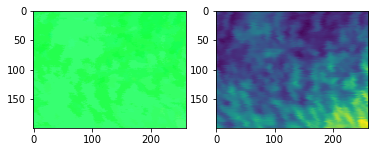

In [15]:
get_ipf_color = sc.get_ipf_color

from orix.quaternion.rotation import Rotation
from orix.vector.vector3d import Vector3d

# convert euler angle lists in result to an orix Rotation object
n_sol = 0 # the index of the solution
solution_y = Rotation.from_euler(np.deg2rad(result["orientation"][:,:,n_sol,:]))

fig, ax = plt.subplots(ncols=2)
# the vector we want to plot on the IPF maps
vectorz = Vector3d([0, 0, 1]).unit
vectory = Vector3d([0, 1, 0]).unit
vectorx = Vector3d([1, 0, 0]).unit
# the information we actually want to plot
sol_y_crop = solution_y
quality_map = result["correlation"][:,:,0]
ax[0].imshow(get_ipf_color(solution_y*vectorz))
ax[1].imshow(quality_map)

## <a id="s3"></a> Masking the dataset
In this section we create a mask from the bright matrix reflections so that the dim precipitate reflections can be indexed

In [20]:
import os

averaged_path = "data/210913AverageExport.hspy"
overwrite=True
if os.path.isfile(averaged_path):
    if not input("Already found an averaged image, recalculate and overwrite? (y/N): ").lower() == "y":
        overwrite = False
if overwrite:
    average = subset.mean()
    average.compute()
    average.save(averaged_path)
else:
    print("Loading the image")
    average = hs.load(averaged_path)

Already found an averaged image, recalculate and overwrite? (y/N): 
Loading the image


Here we threshold the image and slightly grow the boundaries such that the bright regions are thoroughly masked

In [21]:
from skimage.morphology import area_opening, area_closing, dilation, erosion, disk

mask = average.data < 2e-4
for _ in range(3):
    mask = dilation(mask, selem=disk(1))
for _ in range(1):
    mask = erosion(mask, selem=disk(3))
    mask = erosion(mask, selem=disk(2))

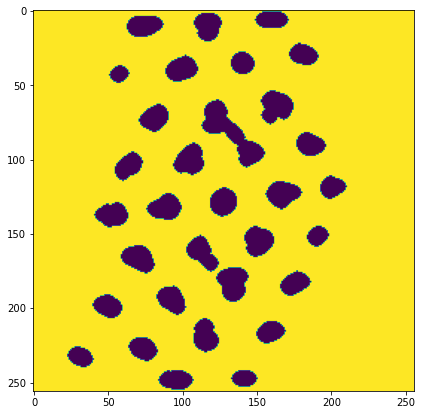

In [22]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(mask)

In [23]:
def mask_image(image):
    return image*mask

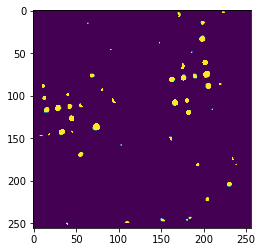

In [24]:
plt.imshow(mask_image(test_image), vmax=0.01)

Here we map the masking over the entire dataset

In [25]:
subset.map(mask_image)

<LazyElectronDiffraction2D, title: , dimensions: (260, 200|256, 256)>

To check the signal that is left, we sum each image in the dataset. This reveals the precipitates.

In [40]:
submap = subset.sum(axis=(2, 3))

In [41]:
submap.compute()

[########################################] | 100% Completed |  1min 58.0s


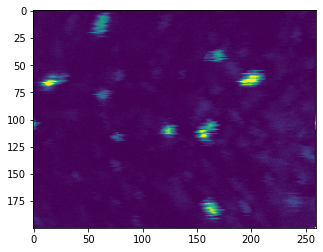

In [42]:
plt.imshow(submap.data, vmax=30)

## <a id="s4"></a> Indexing the G phase

This turned out to be much harder to get decent results due to the strongly modified signal and the complex phase.
We had received an analysis performed with a development version of ASTAR, which on individual patterns looked ok.
This could help us narrow down good parameters.

In [26]:
gres = "data/astar_g.ctf"
import pandas as pd

gresult = pd.read_csv(gres, sep="\t", skiprows=15)
orient_G =  np.array(gresult[["Euler1", "Euler2", "Euler3"]]).reshape(200, 260, 3)

In [27]:
import diffpy
from diffsims.generators.diffraction_generator import DiffractionGenerator
g = diffpy.structure.loadStructure("data/g-phaseLP.cif")

# helper function to plot an image and a diffraction pattern from the ASTAR solution on top of one another
def plot_dp_sim(loc, ex_er=0.1e-1, min_int=1e-7, shf = "lorentzian", vmax=0.01, vmin=0, fudge_factor=1.03, asf = "lobato"):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.axis("off")
    im1 = subset.inav[loc[1], loc[0]]
    im1.compute(parallel=True, optimize_graph=True)
    im1 = im1.data
    ax.imshow(im1, vmax=vmax, vmin=vmin, cmap="inferno")
    orientation = orient_G[loc[0], loc[1]]
    diff_gen = DiffractionGenerator(accelerating_voltage=200,
                                    shape_factor_model=shf,
                                    scattering_params=asf,
                                    minimum_intensity=min_int)
    simulation = diff_gen.calculate_ed_data(
            g,
            reciprocal_radius,
            orientation,
            with_direct_beam=False,
            max_excitation_error=ex_er,
        )
    simulation.calibration = diffraction_calibration*fudge_factor
    cx = im1.shape[1] / 2
    cy = im1.shape[0] / 2
    #simulation.intensities = 1
    ax.scatter(simulation.calibrated_coordinates[:,1]+cx, simulation.calibrated_coordinates[:, 0]+cy,
                s = 5*np.sqrt(simulation.intensities), facecolor="none", edgecolor="red")
    ax.set_xlim(0, im1.shape[1])
    ax.set_ylim(im1.shape[0], 0)
    fig.tight_layout()

[########################################] | 100% Completed |  4.6s


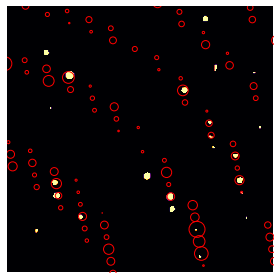

In [28]:
# Some points that are known to contain precipitate reflections. Comment/uncomment to see different images
#point = (104, 161)
#point = (115, 155)
point = (10, 62)

plot_dp_sim(point, shf="linear", asf=None)

### <a id="s4a"></a> Creating a library
Due to the much more closely spaced reflections, a higher sampling and smaller maximum excitation error was required for good results. The peaks in the correlation map were much more narrow - the optimum always existed in a very very small window.

In [29]:
# the necessary imports
import diffpy
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.generators.library_generator import DiffractionLibraryGenerator

from diffsims.generators.rotation_list_generators import get_beam_directions_grid
grid_cub = get_beam_directions_grid("cubic", 0.5, mesh="spherified_cube_edge")

# importing the structures
g = diffpy.structure.loadStructure("data/g-phaseLP.cif")
# fe_bcc = diffpy.structure.loadStructure("data/fe-bcc.cif")

# "The microscope"
diff_gen = DiffractionGenerator(accelerating_voltage=200,
                                shape_factor_model="linear",
                                minimum_intensity=1e-7,
                                scattering_params=None,
                               )
lib_gen = DiffractionLibraryGenerator(diff_gen)

# Generating an gphase library
# "Library of structures and orientations"
library_phases_g = StructureLibrary(["g"], [g], [grid_cub])
#library_phases_bcc = StructureLibrary(["fe"], [fe_bcc], [grid_cub])

/home/din14970/Documents/Programming/PythonProjects/FORKS/diffsims/diffsims/generators/sphere_mesh_generators.py:515: RuntimeWarning: invalid value encountered in true_divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


In [30]:
# Calculate the actual library
import os

lib_path = "data/g_lib_0.5deg_0.01me_1e-7mi.pickle"
overwrite = True
if os.path.isfile(lib_path):
    if not input("Already found a library, overwrite? (y/N): ").lower() == "y":
        overwrite = False
if overwrite:
    # Calculate the actual library
    diff_lib_g = lib_gen.get_diffraction_library(library_phases_g,
                                               calibration=diffraction_calibration*1.03, #fudge factor to match experimental lattice parameter
                                               reciprocal_radius=reciprocal_radius,
                                               half_shape=half_shape,
                                               with_direct_beam=False,
                                               max_excitation_error=1e-2,
                                                )
    # saving the diffraction pattern library out to a file for easy loading
    diff_lib_g.pickle_library(lib_path)
else:
    print("Loading existing library...")
    from diffsims.libraries.diffraction_library import load_DiffractionLibrary
    diff_lib_g = load_DiffractionLibrary(lib_path, True)

Already found a library, overwrite? (y/N): 
Loading existing library...


(<AxesSubplot:>, <matplotlib.collections.PathCollection at 0x7f990c634c10>)

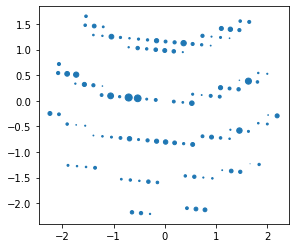

In [31]:
# testing how the diffraction patterns look
fig, ax = plt.subplots()
ax.set_aspect("equal")
number = 100
diff_lib_g["g"]["simulations"][number].plot(ax=ax)

### <a id="s4b"></a> Indexing individual patterns
It turned out additional image processing was necessary to get reliable indexation results:
* a minor gaussian smoothing to widen the peaks
* an additional gamma correction
* a subtraction of a small constant. The effect of this value is to penalize template spots that do not coincide with a spot in the experimental pattern

In [44]:
from skimage.filters import gaussian
#px, py = 15, 67
px, py = 62, 10
#px, py = 64, 77

#px, py = 155, 115
test_image = subset.inav[px, py]
test_image.compute()
test_image.map(gaussian, sigma=1)
print(test_image.data.max(), test_image.data.min())
test_image.map(lambda x: x**0.3-0.05)

[########################################] | 100% Completed |  4.5s


  0%|          | 0/1 [00:00<?, ?it/s]

0.11759614 0.0


  0%|          | 0/1 [00:00<?, ?it/s]

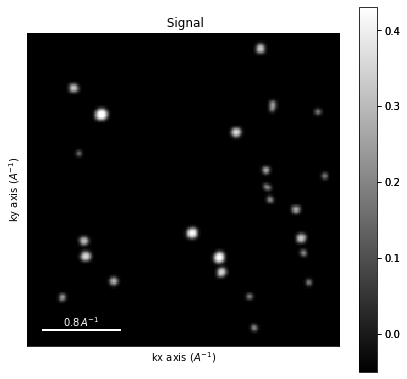

In [33]:
test_image.plot()

In [34]:
from pyxem.utils import indexation_utils as iutls
from pyxem.utils import plotting_utils as putls
from pyxem.utils import polar_transform_utils as ptutls
from pyxem.utils import expt_utils as eutls
from Shortcuts210903NB import grid_to_xy

from diffsims.generators.rotation_list_generators import get_beam_directions_grid
#grid_cub = get_beam_directions_grid("cubic", 1, mesh="spherified_cube_edge")

Due to large differences in template spot intensities which were not experimentally observed, and which were anyway smoothed out by the gamma correction, it doesn't make sense anymore to compare based on spot intensity. Instead, we set all spot intensities to 1, and due to the penalization (see before), the maximum correlation should be the template with the highest number of spots coinciding with bright spots in the image, while avoiding too many spots where there are no bright spots. We also don't normalize the templates, because this seems to unfairly penalizes the templates with high spot count in this instance.

In [35]:
simulations_g = diff_lib_g["g"]["simulations"]

In [36]:
import copy

def func_to_intensity(simulations, function, *args, **kwargs):
    new_sims = []
    for i in simulations:
        new_sim = copy.deepcopy(i)
        new_sim.intensities = function(new_sim.intensities, *args, **kwargs)
        new_sims.append(new_sim)
    return new_sims

In [37]:
simulations = simulations_g

In [38]:
simulations = func_to_intensity(simulations_g, lambda x: (x>0)*1)

-5.980343945372762
1.5190063700056067
(array([0.26747153]), array([0.21482215]))


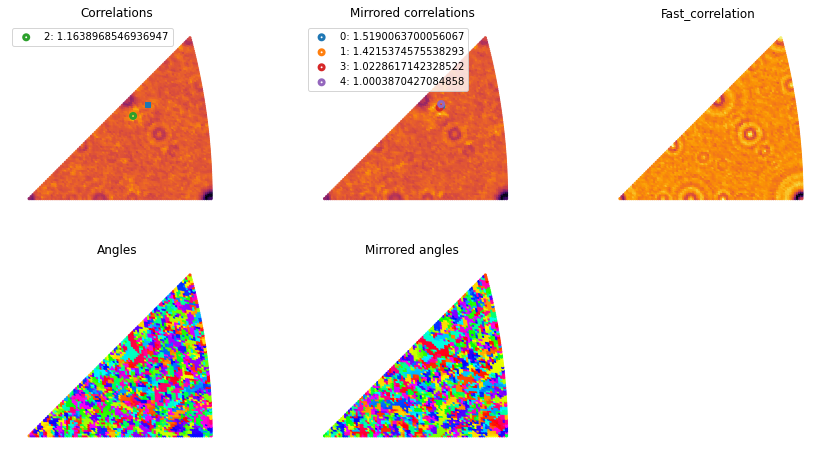

In [39]:
nt = False
fast_cors = iutls.correlate_library_to_pattern_fast(test_image.data, simulations, max_r=115, normalize_image=False, normalize_templates=nt)

indexes, angles, corrs, angles_m, corrs_m = iutls.correlate_library_to_pattern(test_image.data, simulations, max_r=115, normalize_image=False, normalize_templates=nt)
indices_n, angles_n, correlations_n, signs_n = iutls.get_n_best_matches(test_image.data, simulations, n_best=5, max_r=115, normalize_image=False, normalize_templates=nt)

############################
# Plotting the test result #
############################
fig, ax = plt.subplots(ncols = 3, nrows = 2, figsize = (15, 8))
x, y = grid_to_xy(grid_cub)


ax = ax.ravel()
for i in ax:
    i.set_xlim(-0.05, 0.45)
    i.set_ylim(-0.05, 0.4)
    i.axis("off")
    i.set_aspect("equal")
    
s = 5

# to ensure the same color scale on mirror and non-mirror
all_cors = np.stack([corrs, corrs_m])
vmin = all_cors.min()
vmax = all_cors.max()

print(vmin)
print(vmax)

ax[0].scatter(x[indexes], y[indexes], s = s, c = corrs, cmap = "inferno", vmin = vmin, vmax = vmax)
ax[0].set_title("Correlations")
ax[1].scatter(x[indexes], y[indexes], s = s, c = corrs_m, cmap = "inferno", vmin = vmin, vmax = vmax)
ax[1].set_title("Mirrored correlations")
ax[2].scatter(x, y, s = s, c = fast_cors, cmap = "inferno")
ax[2].set_title("Fast_correlation")
ax[3].scatter(x[indexes], y[indexes], s = s, c = angles, cmap = "hsv")
ax[3].set_title("Angles")
ax[4].scatter(x[indexes], y[indexes], s = s, c = angles_m, cmap = "hsv")
ax[4].set_title("Mirrored angles")

for j, (i, ss) in enumerate(zip(indices_n, signs_n)):
    axis = None
    if ss == 1:
        axis = 0
    if ss ==  -1:
        axis = 1
    ax[axis].scatter(x[i], y[i], s = s*5, label = f"{j}: {correlations_n[j]}", edgecolor=f"C{j}", facecolor="None", linewidth=3)

ax[0].legend()
ax[1].legend()
    
# also plot the ASTAR solution
astar_sol = grid_to_xy(orient_G[py, px])
print(astar_sol)
ax[0].scatter(astar_sol[0], astar_sol[1], marker="s", s=s*5)

In [40]:
%matplotlib notebook

<IPython.core.display.Javascript object>


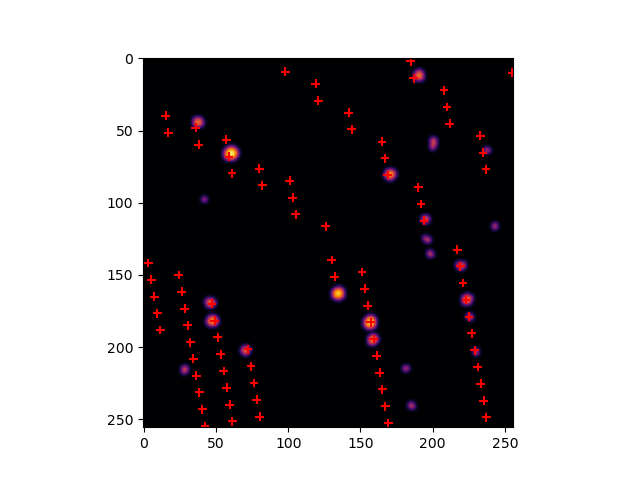

(<AxesSubplot:>,
 <matplotlib.collections.PathCollection at 0x7f990c521fa0>)

In [41]:
# signs will be 1 for the upper triangle, -1 for the lower triangle
sol_inx = 1 # the index of the solution to check
mirrored = signs_n[sol_inx] == -1
putls.plot_template_over_pattern(test_image.data,
                                 simulations[indices_n[sol_inx]],
                                 in_plane_angle=angles_n[sol_inx],
                                 coordinate_system = "cartesian", 
                                 size_factor = 40,
                                 vmax=0.5, 
                                 max_r = 200,
                                 mirrored_template=mirrored,
                                 find_direct_beam=False,
                                 cmap = "inferno",
                                 marker_type="+",
                                )

### <a id="s4c"></a> Indexing the precipitates in the entire dataset

In [46]:
from pyxem.utils import indexation_utils as iutls
from pyxem.utils import plotting_utils as putls
from pyxem.utils import polar_transform_utils as ptutls
from pyxem.utils import expt_utils as eutls
from Shortcuts210903NB import grid_to_xy

In [47]:
from skimage.filters import gaussian
# boost intensities of G-spots more and penalize vacuum
subset.map(gaussian, sigma=1)
subset.map(lambda x: x**0.3-0.05)

<LazyElectronDiffraction2D, title: , dimensions: (260, 200|256, 256)>

In [48]:
import copy
def func_to_intensity(simulations, function, *args, **kwargs):
    new_sims = []
    for i in simulations:
        new_sim = copy.deepcopy(i)
        new_sim.intensities = function(new_sim.intensities, *args, **kwargs)
        new_sims.append(new_sim)
    return new_sims

In [49]:
# adjust intensities of templates to 1
sims = func_to_intensity(diff_lib_g["g"]["simulations"], lambda x: (x>0)*1)
diff_lib_g["g"]["simulations"] = sims

In [51]:
result_g_path = 'outputs/210921ResultG.pickle'

import Shortcuts210903NB as sc
import pickle
import os

overwrite = True
if os.path.isfile(result_g_path):
    if not input("Already found a solution, recalculate and overwrite? (y/N): ").lower() == "y":
        overwrite = False
if overwrite:
    # let's not throw away any templates prematurely and perform a full calculation on all
    # change gpu to cpu if there is no CUDA enabled gpu available!
    res = iutls.index_dataset_with_template_rotation(subset, diff_lib_g, n_best = 5, max_r = 180, normalize_images = False, normalize_templates=False, parallel_workers=4, target="gpu")
    result_g = res[0]
    with open(result_g_path, 'wb') as handle:
        pickle.dump(result_g, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(result_g_path, 'rb') as handle:
        print("Loading data")
        result_g = pickle.load(handle)

Already found a solution, recalculate and overwrite? (y/N): 
Loading data


In [52]:
%matplotlib notebook

<IPython.core.display.Javascript object>


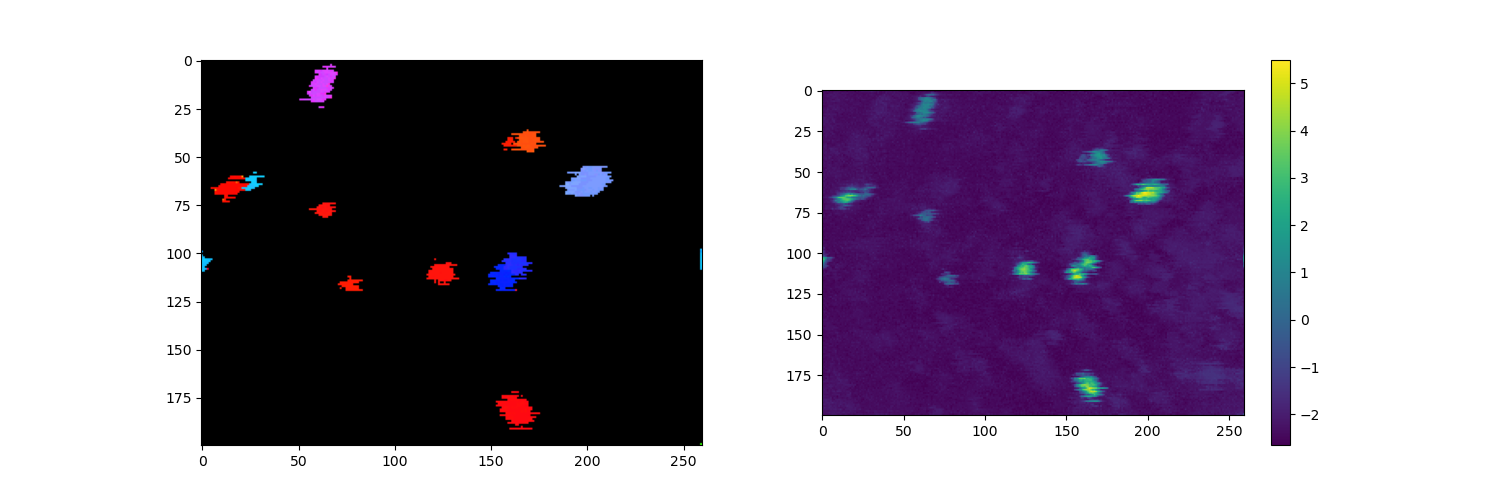

In [53]:
import Shortcuts210903NB as sc
get_ipf_color = sc.get_ipf_color
from orix.quaternion.rotation import Rotation
from orix.vector.vector3d import Vector3d

# convert euler angle lists in result to an orix Rotation object
n_sol = 1 # the index of the solution
solution_y = Rotation.from_euler(np.deg2rad(result_g["orientation"][:,:,n_sol,:]))

fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
# the vector we want to plot on the IPF maps
vectorz = Vector3d([0, 0, 1]).unit
vectory = Vector3d([0, 1, 0]).unit
vectorx = Vector3d([1, 0, 0]).unit
# the information we actually want to plot
sol_y_crop = solution_y
quality_map = result_g["correlation"][:,:,0]

cut_value = 0.016
cut_value = -1.3
quality_mask = quality_map > cut_value
quality_mask_3d = np.stack([quality_mask]*3, axis=-1)

imo = ax[1].imshow(quality_map)
fig.colorbar(imo, ax=ax[1])
ax[0].imshow(get_ipf_color(solution_y*vectorz)*quality_mask_3d)
#ax[0].imshow(get_ipf_color(solution_y*vectorz))
#ax[0].imshow((quality_map > 0.01), alpha=0.5)

In [54]:
plt.close("all")

## <a id="s5"></a>Making a unified figure for the paper

In [2]:
import Shortcuts210903NB as sc
from importlib import reload
reload(sc)

<module 'Shortcuts210903NB' from '/home/din14970/Documents/Programming/PythonProjects/ZZZJupyterNotebook/210903PyxemPaper/Shortcuts210903NB.py'>

In [3]:
data_file = sc.get_processed_gdataset()
average = sc.get_mask_gdataset()
result_aus = sc.get_austenite_result()
data_g = sc.get_masked_gdataset()
result_g = sc.get_g_result()

/home/din14970/Documents/Programming/PythonProjects/FORKS/hyperspy/hyperspy/misc/utils.py:470: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn('Use of the `binned` attribute in metadata is '
/home/din14970/Documents/Programming/PythonProjects/FORKS/hyperspy/hyperspy/io.py:516: VisibleDeprecationWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Setting this attribute for all signal axes instead.
  warnings.warn('Loading old file version. The binned attribute '
/home/din14970/Documents/Programming/PythonProjects/FORKS/hyperspy/hyperspy/misc/utils.py:470: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn('Use of the `binned` attribute in metadata is '
/home/din14970/Documents/Programming/PythonProject

In [4]:
diff_lib_aus = sc.get_diff_lib_aus()
diff_lib_g = sc.get_diff_lib_g()

In [5]:
px = 15
py = 67
plot_image_aus = data_file.inav[px,py]
plot_image_g = data_g.inav[px,py]
plot_image_aus.compute()
plot_image_g.compute()

[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  5.1s


/home/din14970/Documents/Programming/PythonProjects/FORKS/diffsims/diffsims/generators/sphere_mesh_generators.py:515: RuntimeWarning: invalid value encountered in true_divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


Text(0, 0.5, 'Cor. Precip.')

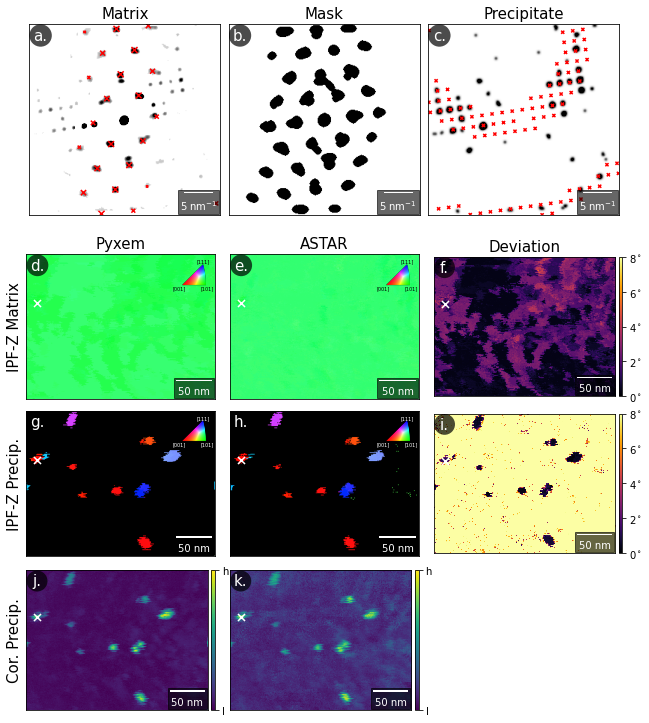

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pyxem.utils.plotting_utils as putls
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
func = lambda x,pos: f"{int(x)}"+r"$^\circ$"
fmt = matplotlib.ticker.FuncFormatter(func)

fig = plt.figure(figsize=(9, 10.2))
bordy = 0.04
#gs = GridSpec(1, 3, height_ratios=[256, 200, 200, 200], left=bordy, right=1-bordy, top=1-bordy, bottom=bordy, wspace=0.01, hspace=[0.01, 0., 0])
gs1 = GridSpec(1, 3, left=bordy, right=1-bordy, top=1-bordy, bottom=0.7, wspace=0.01)
gs2 = GridSpec(3, 3, left=bordy, right=1-bordy, top=0.65, bottom=0.02, wspace=0.08, hspace=0.05)

axes = []
for r in range(4):
    for c in range(3):
        if r*3 + c < 3:
            gs = gs1
            row = r
        else:
            gs = gs2
            row = r-1
        ax = fig.add_subplot(gs[row, c])
        axes.append(ax)
        ax.set_xticks([])
        ax.set_yticks([])

############
# Workflow #
############
imsizex = plot_image_aus.data.shape[1]
imsizey = plot_image_aus.data.shape[0]
for i in range(3):
    axes[i].set_xlim(0, imsizex)
    axes[i].set_ylim(imsizey, 0)
# plotting the best match templates
# austenite information
template_index_aus = result_aus["template_index"][py, px, 0]
sim_aus = diff_lib_aus["austenite"]["simulations"][template_index_aus]
angle_aus = result_aus["orientation"][py, px, 0, 0]  # in-plane angle
mirrored_aus = result_aus["mirrored_template"][py, px, 0]
# g information
template_index_g = result_g["template_index"][py, px, 0]
sim_g = diff_lib_g["g"]["simulations"][template_index_g]
angle_g = result_g["orientation"][py, px, 0, 0]  # in-plane angle
mirrored_g = result_g["mirrored_template"][py, px, 0]

putls.plot_template_over_pattern(plot_image_aus.data, sim_aus, ax=axes[0], in_plane_angle=angle_aus, coordinate_system = "cartesian", 
                                 size_factor = 10, vmax=0.1,  max_r = 200, mirrored_template=mirrored_aus, find_direct_beam=False,
                                 cmap = "Greys",
                                )
putls.plot_template_over_pattern(plot_image_g.data, sim_g, ax=axes[2], in_plane_angle=angle_g, coordinate_system = "cartesian", 
                                 size_factor = 10, vmax=0.2,  max_r = 200, mirrored_template=mirrored_g, find_direct_beam=False,
                                 cmap = "Greys",
                                )
axes[1].imshow(average.data, cmap="Greys_r")

for j in range(3):
    axes[j].add_artist(ScaleBar(sim_aus.calibration[0]*10, units="1/nm", dimension="si-length-reciprocal", location="lower right", box_color="black", color="white", box_alpha=0.6, ))
    
########
# maps #
########
from orix.quaternion.rotation import Rotation
from orix.vector.vector3d import Vector3d
get_ipf_color = sc.get_ipf_color
# convert euler angle lists in result to an orix Rotation object
vectorz = Vector3d([0, 0, 1]).unit
n_sol = 0 # the index of the solution
vectors_aus = Rotation.from_euler(np.deg2rad(result_aus["orientation"][:,:,n_sol,:]))*vectorz
colors_aus = get_ipf_color(vectors_aus)
axes[3].imshow(colors_aus)
vectors_g = Rotation.from_euler(np.deg2rad(result_g["orientation"][:,:,n_sol,:]))*vectorz
colors_g = get_ipf_color(vectors_g)
quality_map = result_g["correlation"][:,:,0]
quality_mask = quality_map > -1.3
quality_mask_3d = np.stack([quality_mask]*3, axis=-1)
axes[6].imshow(colors_g*quality_mask_3d)
qual_g = axes[9].imshow(quality_map)
divider = make_axes_locatable(axes[9])
cax = divider.append_axes("right", size="2%", pad=0.05)
qm = fig.colorbar(qual_g, cax=cax, format=fmt)
qm.set_ticks([quality_map.min(), quality_map.max()])
qm.set_ticklabels(["l", "h"])

#########
# ASTAR #
#########
import pandas as pd
ausresastar = "data/200625ResultsAusteniteNoLin.ctf"
gresastar = "data/astar_g.ctf"
ausresultastar = pd.read_csv(ausresastar, sep="\t", skiprows=14)
gresultastar = pd.read_csv(gresastar, sep="\t", skiprows=15)
orient_aus_astar =  np.array(ausresultastar[["Euler1", "Euler2", "Euler3"]]).reshape(200, 260, 3)
orient_G_astar =  np.array(gresultastar[["Euler1", "Euler2", "Euler3"]]).reshape(200, 260, 3)
quality_map_astar = np.array(gresultastar["BC"]).reshape(200, 260)
quality_mask_as = quality_map_astar > 32
quality_mask_3d_as = np.stack([quality_mask_as]*3, axis=-1)
vectors_aus_as = Rotation.from_euler(np.deg2rad(orient_aus_astar))*vectorz
vectors_g_as = Rotation.from_euler(np.deg2rad(orient_G_astar))*vectorz
axes[4].imshow(get_ipf_color(vectors_aus_as))
axes[7].imshow(get_ipf_color(vectors_g_as)*quality_mask_3d_as)
qual_g_as = axes[10].imshow(quality_map_astar)
divider = make_axes_locatable(axes[10])
cax = divider.append_axes("right", size="2%", pad=0.05)
qm = fig.colorbar(qual_g_as, cax=cax, format=fmt)
qm.set_ticks([quality_map_astar.min(), quality_map_astar.max()])
qm.set_ticklabels(["l", "h"])
###########
# diffmap #
###########


minangle=0
maxangle=8
cm = "inferno"
d1 = axes[5].imshow(np.rad2deg(np.arccos(np.sum(sc.to_fundamental(vectors_aus_as.data)*
                                                sc.to_fundamental(vectors_aus.data), axis=2))),
                   vmin = minangle,
                   vmax = maxangle,
                   cmap = cm
                    )
divider = make_axes_locatable(axes[5])
cax = divider.append_axes("right", size="2%", pad=0.05)
qm = fig.colorbar(d1, cax=cax, format=fmt)
d2 = axes[8].imshow(np.rad2deg(np.arccos(np.sum(sc.to_fundamental(vectors_g_as.data)*
                                                sc.to_fundamental(vectors_g.data), axis=2))),
                   vmin = minangle,
                   vmax = maxangle,
                   cmap = cm
                    )
divider = make_axes_locatable(axes[8])
cax = divider.append_axes("right", size="2%", pad=0.05)
qm = fig.colorbar(d2, cax=cax, format=fmt)

for j in range(3, 11):
    axes[j].add_artist(ScaleBar(1, units="nm", location="lower right", box_color="black", color="white", box_alpha=0.6))
    axes[j].scatter([px], [py], s=50, c="white", marker="x")
    
    
### Stereo triangles legends
triangle = sc.get_stereo_triangle()
for yy in [3, 4, 6, 7]:
    axins = axes[yy].inset_axes([0.81, 0.71, 0.15, 0.3])
    axins.imshow(triangle)
    axins.invert_yaxis()
    axins.axis("off")
    textoptions = {
        "ha": "center",
        "va": "center",
        "fontsize": 5,
    }
    if yy in [6, 7]:
        fontcol = "white"
    else:
        fontcol = "black"
    axins.text(0,0,"[001]", color=fontcol, **textoptions)
    axins.text(triangle.shape[1],0,"[101]", color=fontcol, **textoptions)
    axins.text(0.85*triangle.shape[1],triangle.shape[0],"[111]", color=fontcol, **textoptions)
    
# make letter labels
from matplotlib.patches import Circle, Rectangle

radi = 15
for j,i in enumerate(axes):
    if j<11:
        i.add_patch(Circle((radi,radi), radius=radi, facecolor="black", zorder=10, edgecolor="black",
                    linewidth=0, alpha=0.7))
        i.text(radi, radi, f"{chr(j+97)}.", fontsize=15, ha="center", va="center", color="white", zorder=11)

axes[11].axis("off")


fs = 15
axes[0].set_title("Matrix", fontsize=fs)
axes[1].set_title("Mask", fontsize=fs)
axes[2].set_title("Precipitate", fontsize=fs)
axes[3].set_title("Pyxem", fontsize=fs)
axes[4].set_title("ASTAR", fontsize=fs)
axes[5].set_title("Deviation", fontsize=fs)
axes[3].set_ylabel("IPF-Z Matrix", fontsize=fs)
axes[6].set_ylabel("IPF-Z Precip.", fontsize=fs)
axes[9].set_ylabel("Cor. Precip.", fontsize=fs)

In [10]:
fig.savefig("210903DataImages/210921AnalysisG.png", dpi=640)